<center><font size="10">Mehta Purvil</font></center>
<br><center><font size="6">Github Username: purvilmehta06</font></center>
<br><center><font size="6">USC ID: 6104797766</font></center>

# Installation

In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Packages

In [2]:
import os
import splitfolders
import shutil
import subprocess
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output 
from keras.utils import to_categorical
from keras import layers, models, Model
from keras.applications import EfficientNetB0, ResNet50, VGG16
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc, accuracy_score, ConfusionMatrixDisplay

In [3]:
from google.colab import drive
drive.mount('/content/drive') 

gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Constants

In [4]:
input_images = "/content/drive/MyDrive/ML Project/data/Data/Sport Images"
input_videos = "/content/drive/MyDrive/ML Project/data/Data/Sport Videos"
split_images = "/content/drive/MyDrive/ML Project/data/Data/Split Data"
temp_images = "/content/drive/MyDrive/ML Project/data/Data/Temp/"
pre_trained_weights = "/content/drive/MyDrive/ML Project/data/Pre-trained Weights/"
trained_model_history = "/content/drive/MyDrive/ML Project/data/Stats/"
image_size = (224, 224)
image_shape = (224, 224, 3)
batch_size = 5
output_dropout_rate = 0.2
os.makedirs(trained_model_history, exist_ok = True)

# 1. Transfer Learning for Video Classification

## A. Different Classes

In [5]:
print(sorted(os.listdir(input_images)))

['baseball', 'basketball', 'fencing', 'tennis', 'volleyball']


In [6]:
true_label = {}
idx = 0
for root, dirs, files in os.walk(input_videos, topdown=False):
  dirs.sort()
  for name in dirs:
    true_label[name] = idx
    idx += 1

print(true_label)

{'BaseballPitch': 0, 'Basketball': 1, 'Fencing': 2, 'TennisSwing': 3, 'VolleyballSpiking': 4}


## B. Video Classification 

Videos can be viewed as a sequences of individual images; therefore, one can deal with video classi cation as performing image classi cation L times, where L is the number of frames in a video. However, this setting has a problem: it does not capture the temporal nature of the video. That is why we use RNN-CNN for video classi cation. Training RNN-CNN's needs a lot of computational resources, and it might sometimes be excessive, so in this project we will take a simpler approach.

## C. Moving Averages over Predictions for Video Classification  

In this approach, we train a CNN for image classi cation, and turn it into a video classifier using moving averages. If we rely on only one or a few frames of a video for classifying it, we will observe a phenomenon called 
flickering, which is assigning different labels to different frames of a video in the same class. However, if we use an average of predictions of probabilities for multiple frames, we will get a more reliable prediction for a video 

## D. Data Exploration and Pre-processing

In [7]:
def prepare_data(folder_location):
  data = tf.keras.preprocessing.image_dataset_from_directory(
    folder_location, image_size = image_size, batch_size = batch_size,
  )
  return data.map(lambda x, y: (x, tf.one_hot(y, depth=5)))

In [8]:
## Spliting data into 70-15-15 in train-validation-test respectively
shutil.rmtree(split_images, ignore_errors = True)
splitfolders.ratio(input_images, split_images, seed = 0, ratio = (0.7, 0.15, 0.15))

train_df = prepare_data(split_images + "/train")
test_df = prepare_data(split_images + "/test")
val_df = prepare_data(split_images + "/val")

Found 2292 files belonging to 5 classes.
Found 497 files belonging to 5 classes.
Found 476 files belonging to 5 classes.


## E. Transfer Learning via Image Classification

### i ii iii. Building models, Image augmentation, Last layer configuration 

In [9]:
# Image Augmentation
img_augmentation = models.Sequential(
    [
        layers.RandomRotation(factor = 0.15),
        layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1), 
        layers.RandomFlip(),
        layers.RandomContrast(factor = 0.1),
        # layers.RandomCrop(height = 128, width = 256),
        layers.RandomZoom(height_factor = 0.1) 
    ],
    name = "img_augmentation",
)

# build models
def get_model(model_name, data):
  if model_name == "ResNet50":
    return ResNet50(include_top = False, input_tensor = data, weights = "imagenet")
  if model_name == "EfficientNetB0":
    return EfficientNetB0(include_top = False, input_tensor = data, weights = "imagenet")
  if model_name == "VGG16":
    return VGG16(include_top = False, input_tensor = data, weights = "imagenet")

# adds last layer and its configurations
def build_model(num_classes, model_name):

    inputs = layers.Input(shape = image_shape)
    data = img_augmentation(inputs)

    model = get_model(model_name, data)
    model.trainable = False

    data = layers.GlobalAveragePooling2D(name = "avg_pool")(model.output) 
    data = layers.Activation("relu")(data)
    data = layers.BatchNormalization()(data)
    y = layers.Dropout(output_dropout_rate)(data)    
    outputs = layers.Dense(num_classes, activation = "softmax")(y)
    return Model(inputs, outputs)
  
def get_callback(model_name):
  return [
    tf.keras.callbacks.ModelCheckpoint(filepath = pre_trained_weights + model_name + "_best_weight.hdf5", 
                                       save_weights_only = True, monitor = 'val_accuracy', 
                                       mode = 'auto', save_best_only = True),
    tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'auto', start_from_epoch = 50)
  ]

### iv. Train models

#### VGG16

In [10]:
model_name, epochs = "VGG16", 100

model = build_model(5, model_name)
callbacks = get_callback(model_name)

model.compile(optimizer = Adam(1e-3), loss = "categorical_crossentropy", metrics = ["accuracy"])
hist_training = model.fit(train_df, epochs = epochs, callbacks = callbacks, validation_data = val_df)

np.save(trained_model_history + model_name + '_training.npy', hist_training.history)

58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/100
459/459 [==============================] - 33s 50ms/step - loss: 1.4249 - accuracy: 0.4738 - val_loss: 0.8955 - val_accuracy: 0.7082
Epoch 2/100
459/459 [==============================] - 19s 41ms/step - loss: 1.0073 - accuracy: 0.6313 - val_loss: 0.6117 - val_accuracy: 0.7878
Epoch 3/100
459/459 [==============================] - 20s 43ms/step - loss: 0.9278 - accuracy: 0.6601 - val_loss: 0.5561 - val_accuracy: 0.8306
Epoch 4/100
459/459 [==============================] - 22s 47ms/step - loss: 0.9043 - accuracy: 0.6658 - val_loss: 0.4973 - val_accuracy: 0.8367
Epoch 5/100
459/459 [==============================] - 22s 47ms/step - loss: 0.8651 - accuracy: 0.6784 - val_loss: 0.4703 - val_accuracy: 0.8469
Epoch 6/100
459/459 [==============================] - 22s 47ms/step - loss: 0.8148 - accuracy: 0.7120 - val_loss: 0.5226 - val_accuracy: 0.8245
Epoch 7/100
459/459 [==============================] - 21s 45ms/s

#### EfficientNetB0

In [11]:
model_name, epochs = "EfficientNetB0", 100

model = build_model(5, model_name)
callbacks = get_callback(model_name)

model.compile(optimizer = Adam(1e-3), loss = "categorical_crossentropy", metrics = ["accuracy"])
hist_training = model.fit(train_df, epochs = epochs, callbacks = callbacks, validation_data = val_df)

np.save(trained_model_history + model_name + '_training.npy', hist_training.history)

Epoch 1/100
453/453 [==============================] - 171s 361ms/step - loss: 0.9363 - accuracy: 0.6727 - val_loss: 0.2508 - val_accuracy: 0.9143
Epoch 2/100
453/453 [==============================] - 14s 31ms/step - loss: 0.6949 - accuracy: 0.7663 - val_loss: 0.2253 - val_accuracy: 0.9327
Epoch 3/100
453/453 [==============================] - 13s 29ms/step - loss: 0.6418 - accuracy: 0.7853 - val_loss: 0.2183 - val_accuracy: 0.9327
Epoch 4/100
453/453 [==============================] - 13s 29ms/step - loss: 0.6215 - accuracy: 0.8034 - val_loss: 0.2387 - val_accuracy: 0.9265
Epoch 5/100
453/453 [==============================] - 15s 34ms/step - loss: 0.6099 - accuracy: 0.7951 - val_loss: 0.2216 - val_accuracy: 0.9184
Epoch 6/100
453/453 [==============================] - 13s 29ms/step - loss: 0.5813 - accuracy: 0.7995 - val_loss: 0.2246 - val_accuracy: 0.9306
Epoch 7/100
453/453 [==============================] - 13s 28ms/step - loss: 0.6032 - accuracy: 0.8034 - val_loss: 0.2436 - val_

#### ResNet50

In [12]:
model_name, epochs = "ResNet50", 100

model = build_model(5, model_name)
callbacks = get_callback(model_name)

model.compile(optimizer = Adam(1e-3), loss = "categorical_crossentropy", metrics = ["accuracy"])
hist_training = model.fit(train_df, epochs = epochs, callbacks = callbacks, validation_data = val_df)

np.save(trained_model_history + model_name + '_training.npy', hist_training.history)

Epoch 1/100
459/459 [==============================] - 577s 1s/step - loss: 1.2144 - accuracy: 0.5881 - val_loss: 0.6852 - val_accuracy: 0.7939
Epoch 2/100
459/459 [==============================] - 18s 39ms/step - loss: 0.9320 - accuracy: 0.6955 - val_loss: 0.5685 - val_accuracy: 0.8408
Epoch 3/100
459/459 [==============================] - 19s 42ms/step - loss: 0.9023 - accuracy: 0.7090 - val_loss: 0.5058 - val_accuracy: 0.8551
Epoch 4/100
459/459 [==============================] - 17s 36ms/step - loss: 0.8545 - accuracy: 0.7282 - val_loss: 0.4792 - val_accuracy: 0.8347
Epoch 5/100
459/459 [==============================] - 17s 36ms/step - loss: 0.8569 - accuracy: 0.7299 - val_loss: 0.5222 - val_accuracy: 0.8469
Epoch 6/100
459/459 [==============================] - 18s 40ms/step - loss: 0.8422 - accuracy: 0.7413 - val_loss: 0.4595 - val_accuracy: 0.8571
Epoch 7/100
459/459 [==============================] - 17s 37ms/step - loss: 0.8375 - accuracy: 0.7378 - val_loss: 0.4936 - val_acc

#### Findings

1. Both ResNet50 and EfficientNetB0 has a validation accuracy of 90%-95%. However VGG16 has a validation accuracy of 85%.
2. VGG perfomrs slighly poorly compared to ResNet50 and EfficientNetB0 in terms of validation/training accuracy. This is expected as VGG16 is an older convolutional neural network architecture that was introduced in 2014. It is a relatively shallow network compared to ResNet50 and EfficientNetB0, which were introduced later and are deeper architectures.
3. Early stopping can be seen in all three models: 
  - VGG16: 63 epochs
  - EfficientNetB0: 68 epochs
  - ResNet50: 66 epochs

### v. Plot epoch vs error, confusion matrix, f1-score, accuracy, recall and precision

In [13]:
def plot_epoch_loss(stats, model_name):

    epochs = np.arange(1, len(stats['loss']) + 1)
    fig, axes = plt.subplots(1, 2, figsize = (10, 4))
    axes[0].plot(epochs, np.ones(len(epochs)) - stats['accuracy'], label = "Training Error")
    axes[0].plot(epochs, np.ones(len(epochs)) - stats['val_accuracy'], label = "Validation Error")
    axes[0].set_title("Training and Validation error vs Epochs", fontsize = 10)    
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Error")
    axes[0].legend()

    axes[1].plot(epochs, stats['accuracy'], label = "Training Accuracy")
    axes[1].plot(epochs, stats['val_accuracy'], label = "Validation Accuracy")
    axes[1].set_title("Training and Validation Accuracy vs Epochs", fontsize = 10)    
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    fig.suptitle(model_name)
    plt.show()

def get_prediction_and_true_label(data):
  predictions, labels = [], []
  for x, y in data:
    predictions.append(np.argmax(model.predict(x, verbose = 0), axis = -1).tolist())
    labels.append(np.argmax(y.numpy(), axis=-1).tolist())

  predictions = [c for batch in predictions for c in batch]
  labels = [c for batch in labels for c in batch]
  model_results = classification_report(labels, predictions)
  conf_matrix = confusion_matrix(labels, predictions)
  return model_results, conf_matrix

						 VGG16


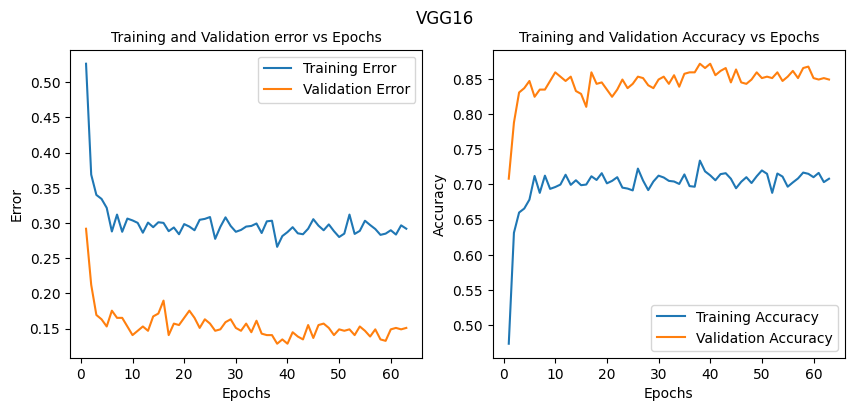

---------------------------------
Printing results for training....
---------------------------------
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       513
           1       0.84      0.88      0.86       344
           2       0.91      0.89      0.90       443
           3       0.90      0.83      0.87       500
           4       0.86      0.89      0.88       492

    accuracy                           0.88      2292
   macro avg       0.88      0.88      0.88      2292
weighted avg       0.88      0.88      0.88      2292

---------------------------------
Printing results for testing.....
---------------------------------
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       111
           1       0.78      0.84      0.81        75
           2       0.83      0.89      0.85        96
           3       0.91      0.82      0.86       108
           4       0.83      0.76   

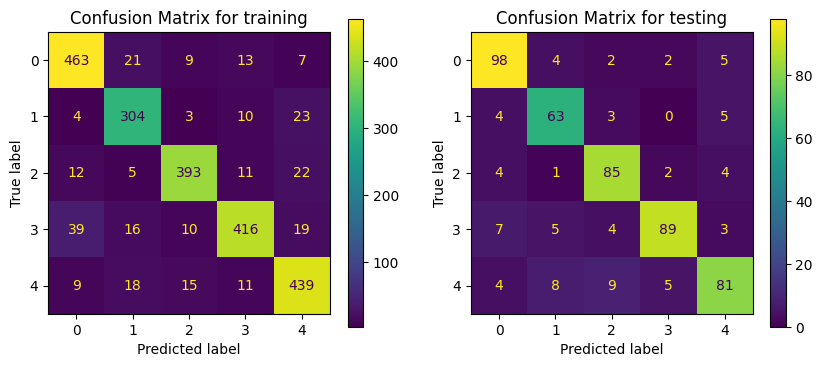

						 EfficientNetB0


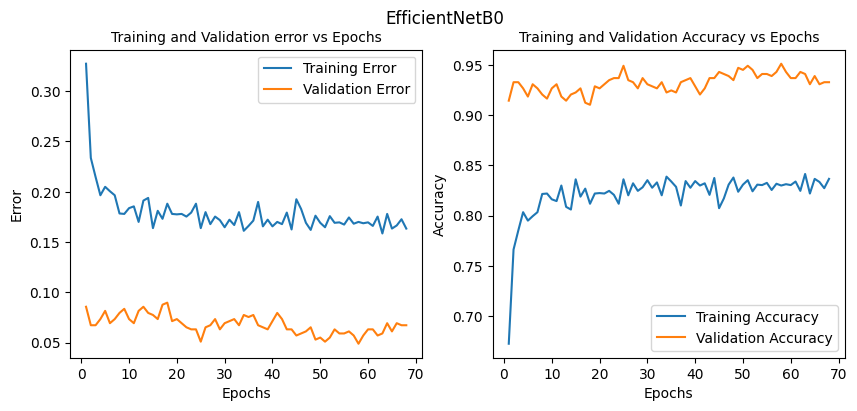

---------------------------------
Printing results for training....
---------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       513
           1       0.97      0.97      0.97       344
           2       0.96      0.96      0.96       443
           3       0.98      0.97      0.98       500
           4       0.97      0.96      0.97       492

    accuracy                           0.97      2292
   macro avg       0.97      0.97      0.97      2292
weighted avg       0.97      0.97      0.97      2292

---------------------------------
Printing results for testing.....
---------------------------------
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       111
           1       0.96      0.91      0.93        75
           2       0.92      0.95      0.93        96
           3       0.89      0.94      0.92       108
           4       0.92      0.92   

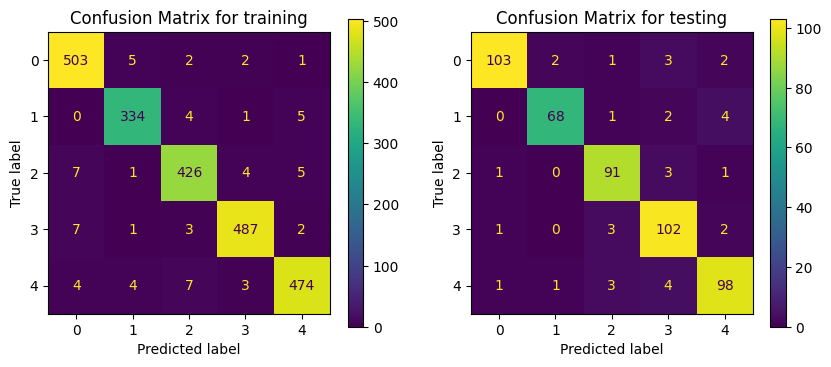

						 ResNet50


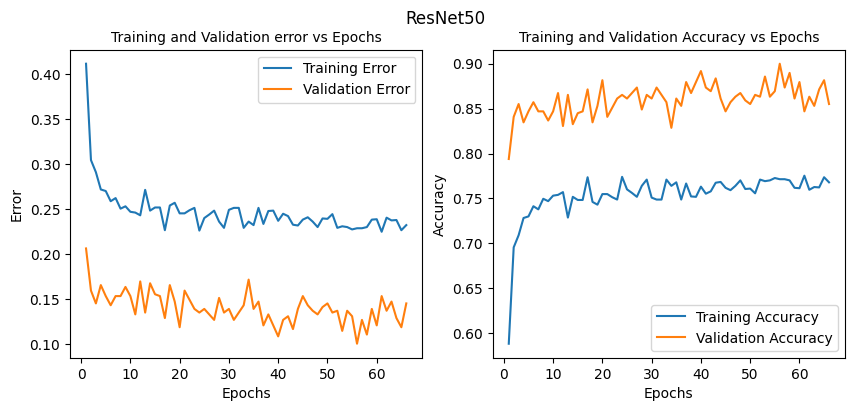

---------------------------------
Printing results for training....
---------------------------------
              precision    recall  f1-score   support

           0       0.90      0.96      0.92       513
           1       0.91      0.93      0.92       344
           2       0.93      0.89      0.91       443
           3       0.94      0.88      0.91       500
           4       0.90      0.91      0.91       492

    accuracy                           0.91      2292
   macro avg       0.92      0.91      0.91      2292
weighted avg       0.92      0.91      0.91      2292

---------------------------------
Printing results for testing.....
---------------------------------
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       111
           1       0.87      0.87      0.87        75
           2       0.92      0.90      0.91        96
           3       0.89      0.89      0.89       108
           4       0.87      0.86   

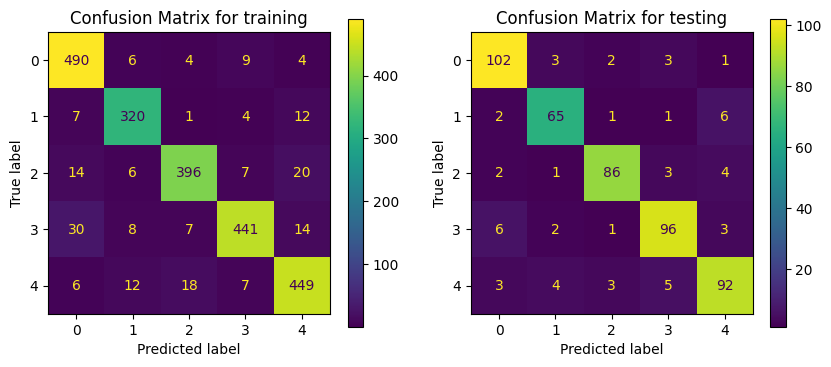

In [14]:
model_names = ['VGG16', 'EfficientNetB0', 'ResNet50']
for model_name in model_names:

  stats = np.load(trained_model_history + model_name + '_training.npy', allow_pickle = True).item()
  model = build_model(5, model_name)
  model.load_weights(pre_trained_weights + model_name + "_best_weight.hdf5")

  print("="*110)
  print("\t\t\t\t\t\t", model_name)
  print("="*110)
  plot_epoch_loss(stats, model_name)

  train_model_results, train_conf_matrix = get_prediction_and_true_label(train_df)
  test_model_results, test_conf_matrix = get_prediction_and_true_label(test_df)

  print("---------------------------------")
  print("Printing results for training....")
  print("---------------------------------")
  print(train_model_results)
  disp = ConfusionMatrixDisplay(train_conf_matrix)
  fig, ax = plt.subplots(1, 2, figsize = (10,4))
  ax[0].set_title("Confusion Matrix for training")
  disp.plot(ax = ax[0])

  print("---------------------------------")
  print("Printing results for testing.....")
  print("---------------------------------")
  print(test_model_results)
  disp = ConfusionMatrixDisplay(test_conf_matrix)
  ax[1].set_title("Confusion Matrix for testing")
  disp.plot(ax = ax[1])
  plt.show()

### Findings: 
1. Test accuracy for VGG16, EfficientNetB0, and ResNet50 are 84%, 92% and 89% respectively. 

## F.  Video Classification Using Moving Averages

### i. Train network over training + validation dataset + test dataset

#### VGG16

In [15]:
full_df = prepare_data(input_images)
model_name = "VGG16"
stats = np.load(trained_model_history + model_name + '_training.npy', allow_pickle = True).item()
epochs = len(stats['loss'])

model = build_model(5, model_name)
model.compile(optimizer = Adam(1e-3), loss = "categorical_crossentropy", metrics = ["accuracy"])
hist_training = model.fit(full_df, epochs = epochs)
np.save(trained_model_history + model_name + '_final.npy', hist_training.history)
model.save_weights(pre_trained_weights + model_name + '_final.hdf5')

Found 3279 files belonging to 5 classes.
Epoch 1/63
656/656 [==============================] - 26s 37ms/step - loss: 1.3162 - accuracy: 0.5169
Epoch 2/63
656/656 [==============================] - 23s 35ms/step - loss: 0.9604 - accuracy: 0.6453
Epoch 3/63
656/656 [==============================] - 23s 35ms/step - loss: 0.8797 - accuracy: 0.6801
Epoch 4/63
656/656 [==============================] - 23s 35ms/step - loss: 0.8347 - accuracy: 0.6993
Epoch 5/63
656/656 [==============================] - 23s 36ms/step - loss: 0.8681 - accuracy: 0.6892
Epoch 6/63
656/656 [==============================] - 24s 36ms/step - loss: 0.8523 - accuracy: 0.6929
Epoch 7/63
656/656 [==============================] - 24s 36ms/step - loss: 0.8384 - accuracy: 0.6953
Epoch 8/63
656/656 [==============================] - 24s 36ms/step - loss: 0.8642 - accuracy: 0.6871
Epoch 9/63
656/656 [==============================] - 24s 36ms/step - loss: 0.8250 - accuracy: 0.6959
Epoch 10/63
656/656 [====================

#### EfficientNetB0

In [16]:
full_df = prepare_data(input_images)
model_name = "EfficientNetB0"
stats = np.load(trained_model_history + model_name + '_training.npy', allow_pickle = True).item()
epochs = len(stats['loss'])

model = build_model(5, model_name)
model.compile(optimizer = Adam(1e-3), loss = "categorical_crossentropy", metrics = ["accuracy"])
hist_training = model.fit(full_df, epochs = epochs)
np.save(trained_model_history + model_name + '_final.npy', hist_training.history)
model.save_weights(pre_trained_weights + model_name + '_final.hdf5')

Found 3279 files belonging to 5 classes.
Epoch 1/68
656/656 [==============================] - 293s 428ms/step - loss: 0.8500 - accuracy: 0.6929
Epoch 2/68
656/656 [==============================] - 17s 25ms/step - loss: 0.6550 - accuracy: 0.7890
Epoch 3/68
656/656 [==============================] - 16s 24ms/step - loss: 0.6355 - accuracy: 0.7868
Epoch 4/68
656/656 [==============================] - 17s 25ms/step - loss: 0.5839 - accuracy: 0.8085
Epoch 5/68
656/656 [==============================] - 17s 26ms/step - loss: 0.6160 - accuracy: 0.8085
Epoch 6/68
656/656 [==============================] - 16s 24ms/step - loss: 0.5697 - accuracy: 0.8185
Epoch 7/68
656/656 [==============================] - 16s 24ms/step - loss: 0.6000 - accuracy: 0.8103
Epoch 8/68
656/656 [==============================] - 16s 24ms/step - loss: 0.5464 - accuracy: 0.8185
Epoch 9/68
656/656 [==============================] - 16s 24ms/step - loss: 0.5679 - accuracy: 0.8137
Epoch 10/68
656/656 [==================

#### ResNet50

In [17]:
full_df = prepare_data(input_images)
model_name = "ResNet50"
stats = np.load(trained_model_history + model_name + '_training.npy', allow_pickle = True).item()
epochs = len(stats['loss'])

model = build_model(5, model_name)
model.compile(optimizer = Adam(1e-3), loss = "categorical_crossentropy", metrics = ["accuracy"])
hist_training = model.fit(full_df, epochs = epochs)
np.save(trained_model_history + model_name + '_final.npy', hist_training.history)
model.save_weights(pre_trained_weights + model_name + '_final.hdf5')

Found 3279 files belonging to 5 classes.
Epoch 1/66
656/656 [==============================] - 28s 33ms/step - loss: 1.1374 - accuracy: 0.6188
Epoch 2/66
656/656 [==============================] - 21s 32ms/step - loss: 0.9495 - accuracy: 0.6956
Epoch 3/66
656/656 [==============================] - 21s 31ms/step - loss: 0.9239 - accuracy: 0.7063
Epoch 4/66
656/656 [==============================] - 21s 32ms/step - loss: 0.8905 - accuracy: 0.7219
Epoch 5/66
656/656 [==============================] - 22s 33ms/step - loss: 0.8915 - accuracy: 0.7194
Epoch 6/66
656/656 [==============================] - 23s 34ms/step - loss: 0.8582 - accuracy: 0.7380
Epoch 7/66
656/656 [==============================] - 21s 32ms/step - loss: 0.8601 - accuracy: 0.7389
Epoch 8/66
656/656 [==============================] - 21s 32ms/step - loss: 0.8364 - accuracy: 0.7365
Epoch 9/66
656/656 [==============================] - 22s 33ms/step - loss: 0.8169 - accuracy: 0.7505
Epoch 10/66
656/656 [====================

### ii, iii, iv Perform video classification

In [18]:
def save_all_frames(video_path, dir_path = temp_images, ext = 'jpg'):
  cap = cv2.VideoCapture(video_path)
  if not cap.isOpened():
    return
  os.makedirs(dir_path + 'Temp', exist_ok = True)
  digit = len(str(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))))
  frame_counts = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  n, total = 1, 0
  while True:
    ret, frame = cap.read()
    if not ret: 
      return
    total += 1
    if ret and (frame_counts <= 100 or (total % int(frame_counts / 100) == 0 and n <= 100)):
      cv2.imwrite(temp_images + 'Temp/img_{}.{}'.format(str(n).zfill(digit), ext), frame)
      n += 1

def get_prediction_for_videos(data, model):
  predictions, labels = [], []
  for x, y in data:
    predictions.extend(model.predict(x, verbose = 0))
  predictions = np.average(np.array(predictions), axis = 0)
  return np.argmax(predictions)

def write_result_to_csv(predicted_labels, actual_labels, 
                        folder_path = trained_model_history):
  predicted_labels = pd.DataFrame(predicted_labels).reset_index(drop = True)
  actual_labels = pd.DataFrame(actual_labels).reset_index(drop = True)
  predicted_labels.columns = ['VGG16_pred', 'EfficientNetB0_pred', 'ResNet50_pred']
  actual_labels.columns = ['VGG16_actual', 'EfficientNetB0_actual', 'ResNet50_actual']
  ans = pd.concat([actual_labels, predicted_labels], axis = 1)
  ans.to_csv(folder_path + "video_classification_output.csv", index = False)

def read_output_csv(file_path = trained_model_history + "video_classification_output.csv"):
  if not os.path.exists(file_path):
    return pd.DataFrame({})
  already_processed_data = pd.read_csv(file_path)
  return already_processed_data

In [19]:
actual_labels = {'VGG16': [], 'EfficientNetB0': [], 'ResNet50': []}
predicted_labels = {'VGG16': [], 'EfficientNetB0': [], 'ResNet50': []}
models = {'VGG16': [], 'EfficientNetB0': [], 'ResNet50': []}
model_names = ['VGG16', 'EfficientNetB0', 'ResNet50']

already_processed_data = read_output_csv()
if already_processed_data.shape[0]:
  for model_name in model_names:
    actual_labels[model_name] = list(already_processed_data[model_name + '_actual'])
    predicted_labels[model_name] = list(already_processed_data[model_name + '_pred'])

for model_name in model_names:
  model = build_model(5, model_name)
  model.load_weights(pre_trained_weights + model_name + "_final.hdf5")
  models[model_name] = model

already_processed_count = len(actual_labels[model_name])
print("Already processed videos: {}".format(already_processed_count))
print("Strating processing from: {}".format(already_processed_count + 1))

count = 0
for folder in sorted(os.listdir(input_videos)):
  for video in os.listdir(input_videos + '/' + folder):

    count += 1
    if count <= already_processed_count:
      continue

    shutil.rmtree(temp_images, ignore_errors = True)
    save_all_frames(input_videos + '/' + folder + '/' + video)
    temp_df = prepare_data(temp_images)
    
    clear_output()
    print("Working on: {}/681".format(count))   
    
    for model_name in model_names:
      predicted_labels[model_name].append(get_prediction_for_videos(temp_df, models[model_name]))
      actual_labels[model_name].append(true_label[folder])

    write_result_to_csv(predicted_labels, actual_labels)
    if count % 5 == 0:
        write_result_to_csv(predicted_labels, actual_labels, "")

shutil.rmtree(temp_images, ignore_errors = True)

Working on: 681/681


Printing testing results for model: VGG16
              precision    recall  f1-score   support

           0       0.68      0.85      0.75       150
           1       1.00      0.05      0.10       137
           2       0.42      0.95      0.58       111
           3       0.66      0.62      0.64       167
           4       0.52      0.34      0.41       116

    accuracy                           0.56       681
   macro avg       0.66      0.56      0.50       681
weighted avg       0.67      0.56      0.51       681



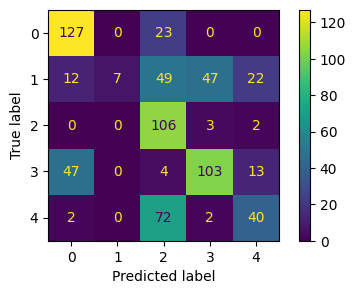

Printing testing results for model: EfficientNetB0
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       150
           1       1.00      0.01      0.01       137
           2       0.35      0.93      0.50       111
           3       0.87      0.73      0.79       167
           4       0.54      0.37      0.44       116

    accuracy                           0.60       681
   macro avg       0.73      0.60      0.53       681
weighted avg       0.76      0.60      0.56       681



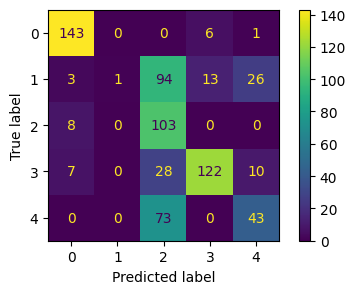

Printing testing results for model: ResNet50
              precision    recall  f1-score   support

           0       0.71      0.87      0.78       150
           1       0.44      0.03      0.05       137
           2       0.35      0.89      0.50       111
           3       0.70      0.65      0.67       167
           4       0.35      0.16      0.21       116

    accuracy                           0.53       681
   macro avg       0.51      0.52      0.45       681
weighted avg       0.53      0.53      0.47       681



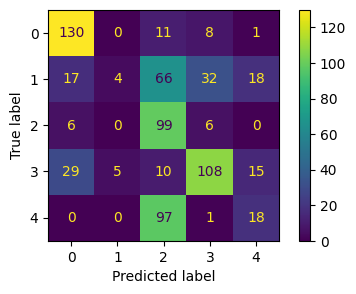

In [20]:
data = read_output_csv()
model_names = ['VGG16', 'EfficientNetB0', 'ResNet50']
for model_name in model_names:
  model_results = classification_report(data[model_name + '_actual'], data[model_name + '_pred'])
  conf_matrix = confusion_matrix(data[model_name + '_actual'], data[model_name + '_pred'])
  print("="*52)
  print("Printing testing results for model: {}".format(model_name))
  print("="*52)
  print(model_results)
  disp = ConfusionMatrixDisplay(conf_matrix)
  fig, ax = plt.subplots(figsize = (5,3))
  disp.plot(ax = ax)
  plt.show()

# Reference

1. https://note.nkmk.me/en/python-opencv-video-to-still-image/
2. https://builtin.com/data-science/transfer-learning
3. https://pyimagesearch.com/2019/07/15/video-classification-with-keras-and-deep-learning/ 